In [1]:
import numpy as np 
import pylab 
import scipy.stats as stats
import pandas as pd
import seaborn as sns
import scipy
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from tqdm.auto import tqdm
from urllib.parse import urlencode
import requests
from scipy.stats import chi2_contingency
plt.style.use('ggplot')

# Task 1

In [2]:
#Reading the data from Yandex disc and opening as dataframe
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_keys = ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', # groups.csv
               'https://disk.yandex.ru/d/3aARY-P9pfaksg', # groups_add.csv
               'https://disk.yandex.ru/d/prbgU-rZpiXVYg', # active_studs.csv
               'https://disk.yandex.ru/d/84hTmELphW2sqQ'] # checks.csv

def import_from_Yandex(link, sp):
    final_url = base_url + urlencode(dict(public_key=link))
    response = requests.get(final_url)
    url = response.json()['href']
    return pd.read_csv(url, sep=sp)


groups      = import_from_Yandex(public_keys[0],';')
groups_add  = import_from_Yandex(public_keys[1],',')
active_students= import_from_Yandex(public_keys[2],',')
checks      = import_from_Yandex(public_keys[3],';')

In [3]:
groups.rename(columns={"id":"student_id"},inplace=True) #giving same name for columns

all_users=(active_students.merge(groups, on='student_id', how='inner')).merge(checks, on='student_id', how='left')
all_users.head()

,student_id,grp,rev
0,581585,A,NaN
1,3276743,B,NaN
2,4238589,A,NaN
3,4475369,B,NaN
4,5481015,B,NaN


Dataframes have been concataneted and cleaned. As more than 80 percent of data in rev column are NaN values, they have been dropped. Otherwise, our test results would be uncorrect.

In [4]:
all_users=all_users.dropna()
all_users.head()

,student_id,grp,rev
61,1184303,A,1530.0000
66,3354191,B,1900.0001
76,3278734,B,1900.0000
98,720651,A,1980.0000
191,1232221,B,1900.0000


In [5]:
groupA = all_users[all_users['grp']=='A']
groupB = all_users[all_users['grp']=='B']
#dividing into two groups


In [6]:
#Lets see some descriptions of two groups
a_group_desc = groupA.rev.describe().to_frame().rename(columns={'rev': 'groupA'})
b_group_desc = groupB.rev.describe().to_frame().rename(columns={'rev': 'groupB'})
pd.concat([a_group_desc, b_group_desc],axis=1).transpose()

,count,mean,std,min,25%,50%,75%,max
groupA,78.0,933.589744,919.932711,199.0,290.0,585.0,1114.75,3660.0
groupB,313.0,1255.827487,791.293377,199.0,489.0,1140.0,1900.00,4650.0


In [7]:
#Now, we can choose which metrics should be chosen to analize the results of the test. As the system of payment
#type was changed, 
# first of all, we should pay attention to the average revenue per paying user and the conversion rate. 

In [8]:
#Now, let's see conversion of the two groups and ARPPU
row_data=(active_students.merge(groups, on='student_id', how='inner')).merge(checks, on='student_id', how='left')
conversion_A=round(row_data.query('grp=="A"').rev.value_counts().sum()/len(row_data.query('grp=="A"').rev),3)
conversion_B=round(row_data.query('grp=="B"').rev.value_counts().sum()/len(row_data.query('grp=="B"').rev),3)
ARPPU_A=round(row_data.query('grp=="A"').rev.sum()/len(groupA.grp),3)
ARPPU_B=round(row_data.query('grp=="B"').rev.sum()/len(groupB.grp),3)
print(f"Conversion rate of group A:     {conversion_A}\nConversion rate of group B:     {conversion_B}\nARPPU of group A:          {ARPPU_A}\nARPPU of group B:          {ARPPU_B}")

Conversion rate of group A:     0.051
Conversion rate of group B:     0.046
ARPPU of group A:          933.59
ARPPU of group B:          1255.827


Now we can check if the differences in the CR and ARPPU are statistically meaningfull or just a coincidence.

# CR 

In [9]:
#For checking CR's meaning, we can use Chi square test, as conversion from active student to costumer have just two value,
#bought or did not, so it is categorical data.

In [10]:
#Null hypothesis:
    #H0: there is no relation in CR and being in group A or B 
    #HA: there is relation in CR and being in group A or B 

In [11]:
row_data['Conversion']=np.where(row_data.rev.isna(), 0, 1) # adding conversion column to use in contingency table

In [12]:
conversion_table=pd.crosstab(row_data.Conversion,row_data.grp)
conversion_table

grp,A,B
Conversion,,
0,1457,6480
1,78,313


In [13]:
stat, p, dof, expected=chi2_contingency(conversion_table)
p

0.46803677583199144

In [14]:
#as p > 0.05  We cannot reject H0, so there is no relation in CR and being in group A or B 

# ARPPU

In [15]:
#Before choosing which statistical test we are going to use, we should check variance of two group, distribution and ect.
#For that Levene test was used below.

In [16]:
stats.levene(groupA['rev'], groupB['rev'] ,center='mean')

LeveneResult(statistic=0.3534952458056376, pvalue=0.5524868375224445)

By checking homegeniuty of variance of two groups we find out that p value is greater than 0.05, that is why we can assume that two groups have different variance.

Checking normality of the sample. But as we can see from the histogram, it is not normally distributed.

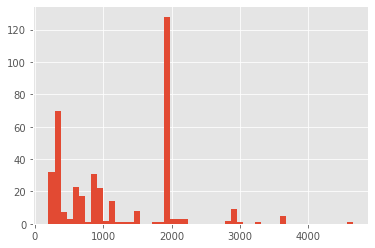

In [17]:
all_users['rev'].hist(bins=50)

As we can see, intial data was not distributed normally and two groups does not have same variance. That is why we cannot use T-test, as assumptions of T-test were not met. In this case, I am going to use Mann-Whitney U test, which is nonparametric version of t-test. Also, bootstrap method could give us more information.

# Bootstrap 

In [18]:
# Declare a function that will allow us to test hypotheses using the bootstrap
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
# Butstrap kullanarak hipotezleri test etmemize izin verecek bir fonksiyon 
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки  # numeric values of the first sample # ilk örneğin sayısal değerleri
    data_column_2, # числовые значения второй выборки # numeric values of the second sample # ikinci örneğin sayısal değerleri
    boot_it = 1000, # количество бутстрэп-подвыборок  # number of bootstrap subsamples # önyükleme alt örneklerinin sayısı
    statistic = np.mean, # интересующая нас статистика # statistics we are interested in # ilgilendiğimiz istatistikler
    bootstrap_conf_level = 0.95 # уровень значимости # significance level # önem düzeyi
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_mean = []
    for i in range(boot_it): # извлекаем подвыборки # alt örnekleri çıkar # extract subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения # return parameter # dönüş parametresi
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data_mean.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data_mean)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data_mean), 
        scale = np.std(boot_data_mean)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data_mean), 
        scale = np.std(boot_data_mean)
    )
    p_value = min(p_1, p_2) * 2
        
    return {"p_value": p_value}

In [19]:
# Declare a function that will allow us to test hypotheses using the bootstrap
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
# Butstrap kullanarak hipotezleri test etmemize izin verecek bir fonksiyon 
def get_bootstrap_median(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data_median = []
    for i in range(boot_it): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data_median.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data_median)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data_median), 
        scale = np.std(boot_data_median)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data_median), 
        scale = np.std(boot_data_median)
    )
    p_value = min(p_1, p_2) * 2
    
       
    return {"p_value": p_value}

In [20]:
x=groupA['rev']
y=groupB['rev']
MW=mannwhitneyu(groupA['rev'], groupB['rev'])
for i in range(10):
    boot_mean=get_bootstrap_mean(x,y)
    boot_median=get_bootstrap_median(x,y)
    print(f'Boot mean: {boot_mean["p_value"]},       Boot median:{boot_mean["p_value"]},      MN {MW.pvalue}')

Boot mean: 1.4000526046977855e-06,       Boot median:1.4000526046977855e-06,      MN 0.000273244700505943
Boot mean: 1.2994584271543735e-06,       Boot median:1.2994584271543735e-06,      MN 0.000273244700505943
Boot mean: 4.8921787863195435e-06,       Boot median:4.8921787863195435e-06,      MN 0.000273244700505943
Boot mean: 3.646720156316577e-06,       Boot median:3.646720156316577e-06,      MN 0.000273244700505943
Boot mean: 3.0942837182703024e-06,       Boot median:3.0942837182703024e-06,      MN 0.000273244700505943
Boot mean: 1.571898510207019e-06,       Boot median:1.571898510207019e-06,      MN 0.000273244700505943
Boot mean: 3.0442854206473088e-06,       Boot median:3.0442854206473088e-06,      MN 0.000273244700505943
Boot mean: 1.9974900163968618e-06,       Boot median:1.9974900163968618e-06,      MN 0.000273244700505943
Boot mean: 2.3090541334954063e-06,       Boot median:2.3090541334954063e-06,      MN 0.000273244700505943
Boot mean: 8.743493781131256e-07,       Boot media

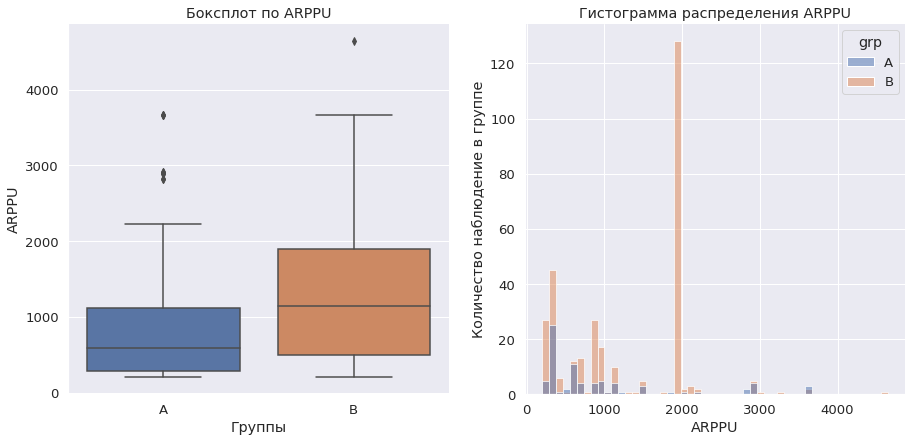

In [21]:
sns.set(font_scale=1.2, style="darkgrid", rc={'figure.figsize':(15,15)})
plt.subplot(221)
ax =  sns.boxplot(data=row_data.loc[row_data.Conversion==1], x='grp', y='rev')
ax.set_xlabel('Группы')
ax.set_ylabel('ARPPU')
ax.set_title('Боксплот по ARPPU')
sns.despine()

plt.subplot(222)
ax = sns.histplot(data=row_data.loc[row_data.Conversion==1], x='rev', hue='grp', bins=50)
ax.set_xlabel('ARPPU')
ax.set_ylabel('Количество наблюдение в группе')
ax.set_title('Гистограмма распределения ARPPU')
sns.despine()

На какие метрики Вы смотрите в ходе анализа и почему?
Имеются ли различия в показателях и с чем они могут быть связаны?
Являются ли эти различия статистически значимыми?
Стоит ли запускать новую механику на всех пользователей?

We are paying more attention to ARPPU of students, as there is no big difference in conversion rate in two groups. Difference in CR turned out to be not statistically significant. But  ARPPU differs by 324,29 which is 25 percent difference. And those differences are statistically significant because of the t ests we have done and conclusion it brought us. Difference in ARPPU might be because of the more accessable type of payment, for example if the student could pay the course with installments for 12 month, they could afford more courses at the same time or the expensive ones. But the reason that conversion of the group B was less than A might be because student were always used to initial type of payment and they were not considering or wanting other type of payment. But of course, because of luck of information, we cannot say exact reasons. TO know it, we should have how many students were new and how many students were old. But overall, i think that data for analisys was poorly selected and not sufficent to give important advice. 
We can notice that in the group B, number of students who bougth course on 1900 RUB. We could analize those students by age, school, interest area or anything which makes them in one group, so we could use the new payment type for such groups. 
So, as a conclusion, we can say that the new type of the payment could increase ARPPU, so we can use it for specific students. 

# Task 3

Function returning the new metrics with groups_add file

In [22]:
def metrics(add_url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_keys = ['https://disk.yandex.ru/d/58Us0DWOzuWAjg', # groups.csv
               'https://disk.yandex.ru/d/prbgU-rZpiXVYg', # active_studs.csv
               'https://disk.yandex.ru/d/84hTmELphW2sqQ'] # checks.csv

    def import_from_Yandex(link, sp):
        final_url = base_url + urlencode(dict(public_key=link))
        response = requests.get(final_url)
        url = response.json()['href']
        return pd.read_csv(url, sep=sp)

    #reading files
    groups      = import_from_Yandex(public_keys[0],';')
    groups_add  = import_from_Yandex(add_url,',')
    active_students= import_from_Yandex(public_keys[1],',')
    checks      = import_from_Yandex(public_keys[2],';')
    #cleaning the data and concatenating
    groups=groups.rename(columns={"id":"student_id"})
    groups_add=groups_add.rename(columns={"id":"student_id"})
    groups_all=pd.concat([groups,groups_add])
    all_students_group=(active_students.merge(groups_all, on='student_id', how='inner'))
    conv_data=(checks.merge(all_students_group, on='student_id', how='right'))
    groupA = conv_data[conv_data['grp']=='A']
    groupB = conv_data[conv_data['grp']=='B']
    #finding conversion rate and ARPPU
    conversion_A=round(conv_data.query('grp=="A"').rev.value_counts().sum()/len(conv_data.query('grp=="A"').rev),3)
    conversion_B=round(conv_data.query('grp=="B"').rev.value_counts().sum()/len(conv_data.query('grp=="B"').rev),3)
    ARPPU_A=round(conv_data.query('grp=="A"').rev.sum()/len(conv_data.query('grp=="A" and rev>0').rev),3)
    ARPPU_B=round(conv_data.query('grp=="B"').rev.sum()/len(conv_data.query('grp=="B" and rev>0').rev),3)
     
    #creating df 
    data = {'Conversion_rate': [conversion_A,conversion_B],'ARPPU': [ARPPU_A, ARPPU_B]}
  
    # Creates pandas DataFrame.
    df = pd.DataFrame(data, index=['Group A','Group B'])
    
    #task3.2 graph of metrics
    sns.set(palette="gist_earth", 
            rc={"axes.grid":True,
            "grid.color": "lightgrey",
            'axes.grid.axis':'y',
            'axes.facecolor': 'white'})
    
    f, ax = plt.subplots(1,2,figsize=(20,4))
    
    
    sns.barplot(x = ['Group A', 'Group B'], y=[df.Conversion_rate[0],df.Conversion_rate[1]], ax=ax[0])
    ax[0].fill_between([0.4,0.6],
                     [df.Conversion_rate[0],df.Conversion_rate[1]], alpha=0.6)
    
    sns.barplot(x =['Group A', 'Group B'], y=[df.ARPPU[0],df.ARPPU[1]], ax=ax[1])
    ax[1].fill_between([0.4,0.6],
                     [df.ARPPU[0],df.ARPPU[1]], alpha=0.6)
    
    ax[0].set_title('CR')
    ax[1].set_title('ARPPU')
   

    
    return(df)

         Conversion_rate     ARPPU
Group A            0.051   933.590
Group B            0.046  1257.879


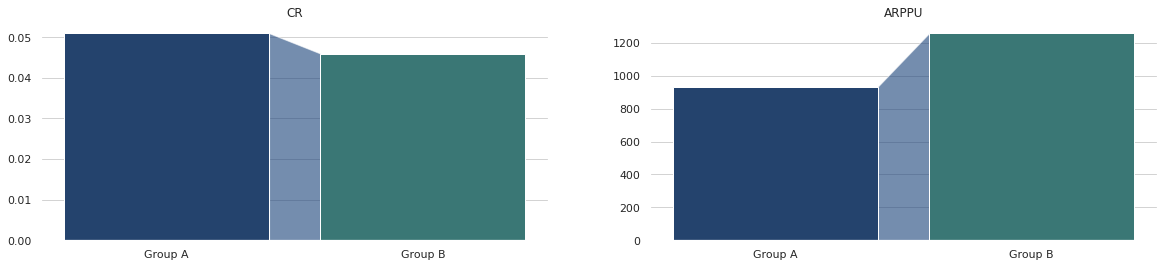

In [23]:
print(metrics('https://disk.yandex.ru/d/3aARY-P9pfaksg'))  